In [10]:
import json
import numpy as np
import matplotlib.pyplot as plt
import re
from matplotlib.colors import LogNorm
import copy
import glob
from hessian import *
from system import *

import matplotlib
font = {'family' : 'normal',
        #'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

In [11]:
all_coords = get_modes("monomer_normal_modes.molden", 414, 140)

# Single (truncated) BChla

In [12]:
wavenumbers = get_wavenumbers("monomer_normal_modes.molden")
frequencies = wavenumber_to_frequency(wavenumbers)

In [13]:
CO = [enum for enum, x in enumerate(wavenumbers) if x > 1600 and x < 1800]
CO

[333, 334, 335, 336, 337, 338, 339]

In [14]:
output_files = [x for x in glob.glob("monomer_8*.molden") if "normal_modes" not in x]
output_files

['monomer_855.molden',
 'monomer_863.molden',
 'monomer_849.molden',
 'monomer_857.molden',
 'monomer_873.molden',
 'monomer_861.molden',
 'monomer_869.molden',
 'monomer_875.molden',
 'monomer_867.molden',
 'monomer_879.molden',
 'monomer_851.molden',
 'monomer_870.molden',
 'monomer_858.molden',
 'monomer_846.molden',
 'monomer_854.molden',
 'monomer_881.molden',
 'monomer_878.molden',
 'monomer_866.molden']

monomer_855.molden
monomer_863.molden
monomer_849.molden
monomer_857.molden
monomer_873.molden
monomer_861.molden
monomer_869.molden
monomer_875.molden
monomer_867.molden
monomer_879.molden
monomer_851.molden
monomer_870.molden
monomer_858.molden
monomer_846.molden
monomer_854.molden
monomer_881.molden
monomer_878.molden
monomer_866.molden


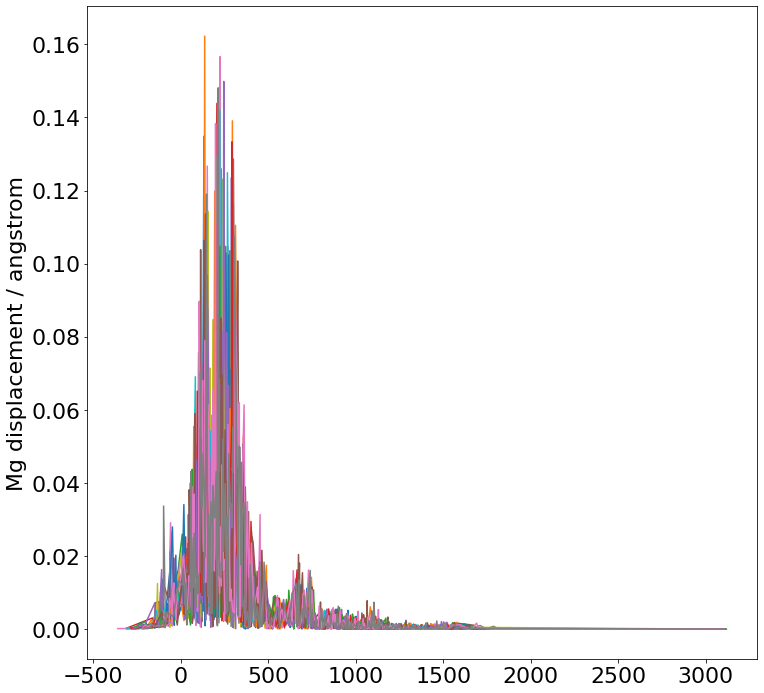

In [15]:
fig, ax = plt.subplots()

n_atoms = 140
n_modes = 3 * n_atoms - 6

Mg_index = 0

for i in output_files:
    print(i)
    all_displacements = get_all_displacements(i, n_atoms, n_modes)

    wavenumbers = get_wavenumbers(i)
    frequencies = wavenumber_to_frequency(wavenumbers)

    ax.plot(wavenumbers, all_displacements[Mg_index])

    #np.save(i.replace(".molden", "_hess_frequencies"), frequencies)
    #np.save(i.replace(".molden", "_hess_displacements"), all_displacements[Mg_index])

#ax.set_xlim(3e-3, 2e-2)
ax.set_ylabel("Mg displacement / angstrom")
#ax.set_xlabel("frequency / $\mathrm{fs}^{-1}$")

#ax.set_xscale('log')

fig.set_size_inches(12,12)

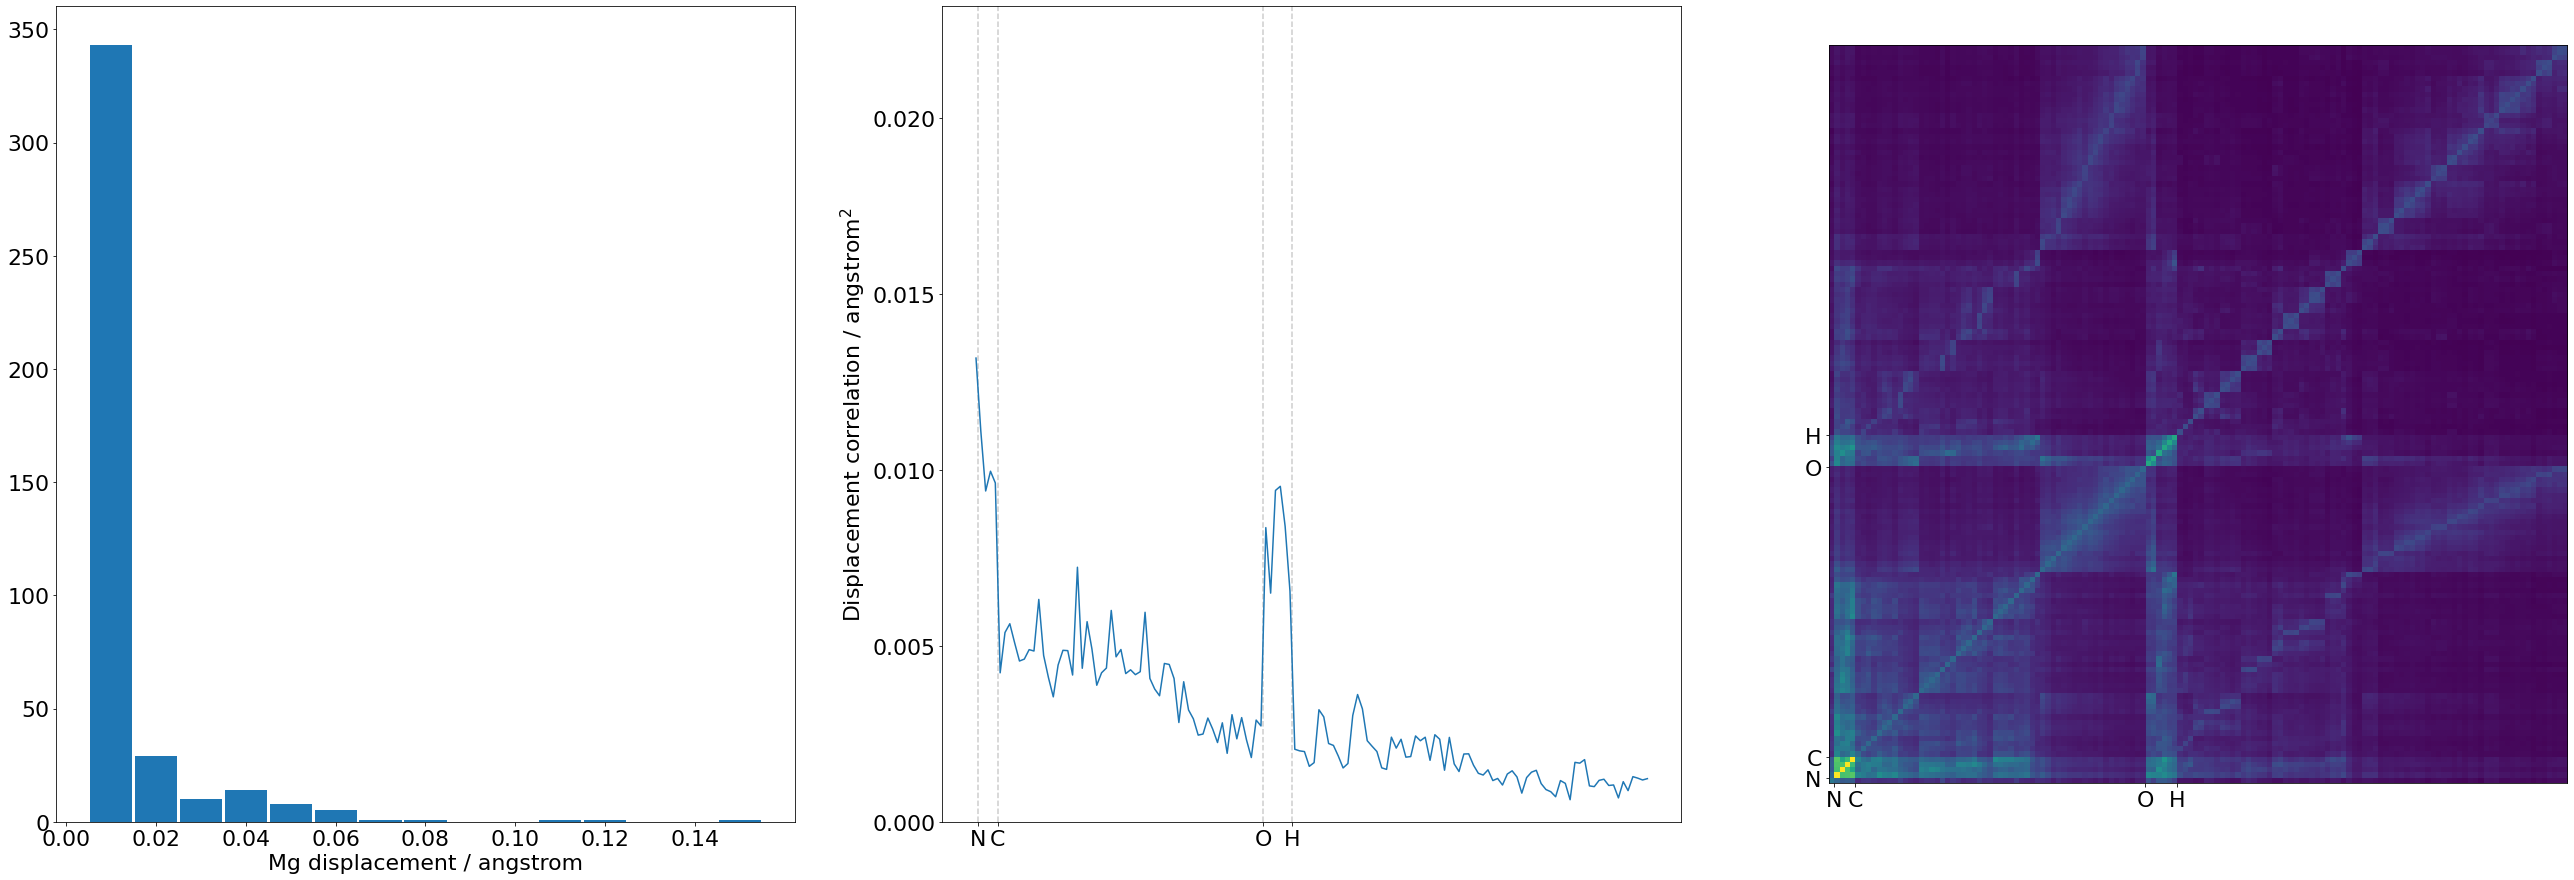

In [16]:
fig, ax = plt.subplots(1, 3)

symbols = read_symbols("monomer.xyz")

Mg_indices= get_indices(symbols, "Mg")
N_indices = get_indices(symbols, "N")
C_indices = get_indices(symbols, "C")
O_indices = get_indices(symbols, "O")
H_indices = get_indices(symbols, "H")

Mg_max_disp= all_displacements[Mg_indices].max()
N_max_disp = all_displacements[N_indices].max()
C_max_disp = all_displacements[C_indices].max()
O_max_disp = all_displacements[O_indices].max()
H_max_disp = all_displacements[H_indices].max()

normalized_displacements = copy.copy(all_displacements)

normalized_displacements[Mg_indices]/= Mg_max_disp
normalized_displacements[N_indices] /= N_max_disp
normalized_displacements[C_indices] /= C_max_disp
normalized_displacements[O_indices] /= O_max_disp
normalized_displacements[H_indices] /= H_max_disp

grouped_symbols = np.concatenate((Mg_indices, N_indices, C_indices, O_indices, H_indices))

normalized_displacements = normalized_displacements[grouped_symbols]

bins = np.linspace(0, 0.15, 16)
his = np.histogram(all_displacements[Mg_index], bins=bins)

ax[0].bar(his[1][1:], his[0], width=0.15/len(bins), align='center')
ax[0].set_xticks(bins[::2])

ax[0].set_xlabel("Mg displacement / angstrom")
ax[1].set_ylabel("Frequency")

Mg_displacements = np.where(all_displacements[Mg_index] > 0.0)[0]

correlation = np.zeros((n_atoms, n_atoms))

for i in Mg_displacements:
    correlation += np.outer(normalized_displacements[:,i], normalized_displacements[:,i])
    
correlation /= len(Mg_displacements)

cax = ax[2].imshow(correlation, origin='lower', cmap=plt.get_cmap('viridis'))#, norm=LogNorm(vmin=0.0001, vmax=20))
    
#fig.colorbar(cax)

def ticks(symbols):
    Mg_indices= get_indices(symbols, "Mg")
    N_indices = get_indices(symbols, "N")
    C_indices = get_indices(symbols, "C")
    O_indices = get_indices(symbols, "O")
    H_indices = get_indices(symbols, "H")
    
    lengths = [len(Mg_indices), len(N_indices), len(C_indices), len(O_indices), len(H_indices)]
    
    cumulative = np.cumsum(lengths)
    
    ticks = np.array([x - 0.5 for x in cumulative[:-1]])
    
    return ticks

# number of each element --  Mg: 1, N: 4, C: 55, O: 6, H: 74
# cumulative -- 1, 5, 39, 43, 79

symbol_ticks = ticks(symbols)
symbol_labels= ["N","C","O","H"]

ax[2].set_xticks(symbol_ticks)
ax[2].set_xticklabels(symbol_labels)

ax[2].set_yticks(symbol_ticks)
ax[2].set_yticklabels(symbol_labels)

ax[1].plot(correlation[0])
ax[1].set_xticks(symbol_ticks)
ax[1].set_xticklabels(symbol_labels)
ax[1].set_ylabel("Displacement correlation / $\mathrm{angstrom}^2$")

ax[1].vlines(symbol_ticks, color='black', linestyle='--', ymin=0, ymax=max(correlation[0])+0.01, alpha=0.2)
ax[1].set_ylim(0, max(correlation[0])+0.01)

fig.set_size_inches(45,15)

[-213.70681  -170.096419 -166.587446 -161.522667 -115.186414 -102.401741
  -88.724277  -79.280584  -41.723528  -41.455134  -34.387591  -11.326365
   11.147114   15.443312   25.493179   28.094518   29.055186   35.134684
   36.794797   40.791226   49.885214   52.364451   54.604339   58.650205
   63.194551   64.66863    72.373932   75.161151   78.023669   79.124123
   82.278469   87.881419   94.357995   98.992356  100.98076   109.879851
  112.595908  113.453308  117.911819  118.60284   122.216753  128.084746
  135.743402  137.737503  140.175572  144.746432  148.030834  155.30101
  158.522314  163.721189  166.355802  169.377666  173.313544  180.383612
  180.963661  184.229058  191.015122  194.979833  203.35233   210.360567
  214.788648  215.105705  216.141352  221.704931  231.76435   232.7075
  233.988171  234.527411  241.19013   245.696469  254.172701  258.054504
  262.346161  266.292698  268.050161  275.128528  282.191242  290.917155
  294.100404  299.935874  300.278298  307.317137  328.

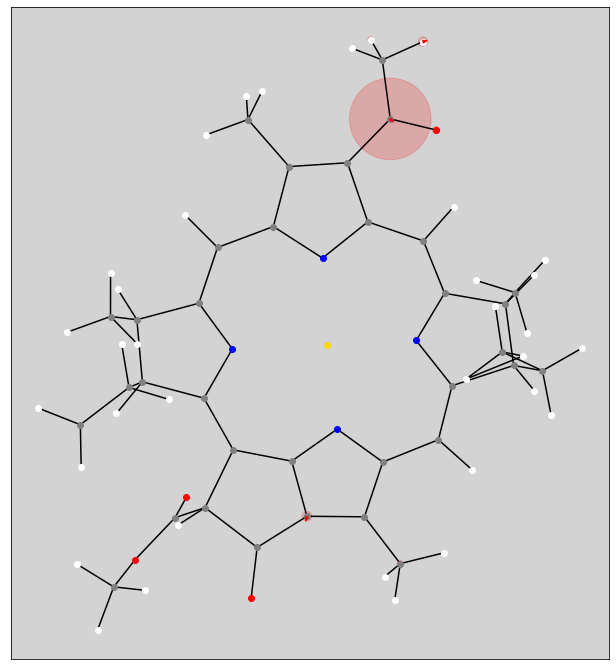

In [29]:
symbols = read_symbols("opt_bchla.xyz")

bchla_in_xy_plane, rotation_matrix = get_bchla_in_xy_plane()

fig, ax = plt.subplots()

plot_molecule(bchla_in_xy_plane, symbols, ax)

max_mg_modes = np.argsort(all_displacements[0])[::-1]

print(wavenumbers)

for m in [339]:
    mode = normalized_displacements[:, m]    
    for n in range(140):
        if n in phytol_indices():
            continue
            
        circle = plt.Circle((bchla_in_xy_plane[n][0], bchla_in_xy_plane[n][1]), mode[n], color='r', alpha=0.2, zorder=0)
        ax.add_patch(circle)
                
        if mode[n] > 1e-1:
            disp_vec = np.matmul(rotation_matrix, np.array([all_coords[n][0][m], all_coords[n][1][m], all_coords[n][2][m]]))

            ax.arrow(bchla_in_xy_plane[n][0], bchla_in_xy_plane[n][1], disp_vec[1], disp_vec[2], head_width=0.07, color='red')
        
        

ax.set_yticks([])
ax.set_xticks([])
        
fig.set_size_inches(12,12)

In [31]:
1/wavenumber_to_frequency(1600)

20.8477559498845